In [22]:
import tensorflow as tf
from keras.preprocessing import image
import cv2
import numpy as n
import os
from keras.applications import imagenet_utils

from matplotlib import pyplot as plt
from PIL.Image import Image
from PIL import Image as im
from tensorflow import Tensor

In [23]:
model = tf.keras.models.load_model(os.path.join('models', 'signclassifier.h5'))

In [24]:
class FGSMAttack():

    def __init__(self, source_image_path: str, epsilon : float, input_label: int) -> None:

        """
        Clase que implementa el ataque FGSM (Fast Gradient Sign Method) para generar una imagen adversarial.

        Atributos:
        - source_image_path: Ruta de la imagen original.
        - epsilon: Valor de la perturbación.
        - input_label: Etiqueta de la clase objetivo.
        - source_image: Imagen original preprocesada.
        - loss_object: Función de pérdida utilizada para el ataque.
        - adversarial_pattern: Patrón adversario generado.
        - adversarial_image: Imagen adversaria generada.
        
        """

        self.epsilon = epsilon
        self.input_label = self.__get_label(input_label)

        self.source_image = self.__preprocess_image(source_image_path)
        self.pretrained_model = model

        self.loss_object = tf.keras.losses.CategoricalCrossentropy()
        
        self.adversarial_pattern = self.__generate_adversarial_pattern()

        self.adversarial_image = self.__generate_adversarial_image()

    def __preprocess_image(self, image_path: str) -> Tensor:
        image_raw = tf.io.read_file(image_path)
        image = tf.image.decode_image(image_raw)
        image = tf.cast(image, tf.float32)
        image = self.__resize_image(image)
        image = image[None, ...]

        image = imagenet_utils.preprocess_input(
            image, data_format=None, mode="tf"
        )

        return image
    
    def __resize_image(self, image: Tensor) -> Tensor:
        return tf.image.resize(image, [256, 256])

    def __generate_adversarial_image(self) -> Tensor:
        adv_img = self.source_image + (self.epsilon * self.adversarial_pattern)
        adv_img = tf.clip_by_value(adv_img, -1, 1)
        return adv_img

    def __generate_adversarial_pattern(self) -> Tensor:
        with tf.GradientTape() as tape:
            tape.watch(self.source_image)
            prediction = self.pretrained_model(self.source_image)
            loss = self.loss_object(self.input_label, prediction)

        # Get the gradients of the loss w.r.t to the input image.
        gradient = tape.gradient(loss, self.source_image)
        # Get the sign of the gradients to create the perturbation
        signed_grad = tf.sign(gradient)
        
        return signed_grad
    
    def get_adversarial_image(self) -> Tensor:
        return self.adversarial_image
    
    def get_adversarial_pattern(self) -> Tensor:
        return self.adversarial_pattern
    
    def get_source_image(self) -> Tensor:
        return self.source_image
    
    def __get_label(self, class_index: int) -> Tensor:
        label = tf.one_hot(class_index, 4)
        label = tf.reshape(label, (1, 4))

        return label
    


Clase 120kmh-sign terminada. 101 ejemplos generados.
Clase 50kmh-sign terminada. 42 ejemplos generados.
Clase radar-sign terminada. 84 ejemplos generados.
Clase stop-sign terminada. 114 ejemplos generados.


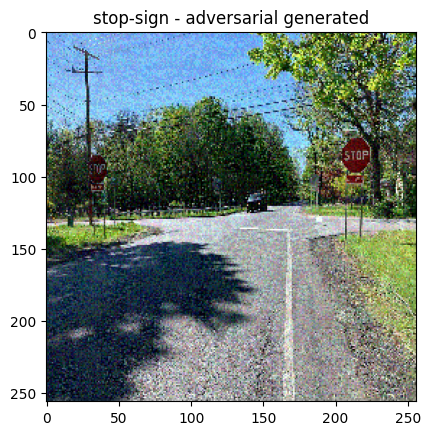

In [25]:
# Generar ejemplos adversarios para la clases

source_image_path = os.path.join('data')
epsilon = 0.15

for image_class in os.listdir(source_image_path): 
    i = 0
    for image in os.listdir(os.path.join(source_image_path, image_class)):
        
        image_path = os.path.join(source_image_path, image_class, image)
        try: 
            
            img = cv2.imread(image_path)
            resize = tf.image.resize(img, [256, 256])
            yhat = model(n.expand_dims(resize/255, axis=0))

            
            n.argmax(yhat)
            attack = FGSMAttack(image_path, epsilon, int(n.argmax(yhat)))
            adversarial_image = attack.get_adversarial_image()
            

            image_np = adversarial_image.numpy()
            adversarial_image = im.fromarray(((image_np[0] + 1) * 127.5).astype("uint8"))
            plt.title(image_class + " - adversarial generated") 
            plt.imshow(adversarial_image)
            
            adversarial_image_path = os.path.join('adversarial-examples', image_class, 'adversarial_'+image)
            if not os.path.exists(os.path.join('adversarial-examples', image_class)):
                os.makedirs(os.path.join('adversarial-examples', image_class))

                        
            # Primero, ajusta la escala a [0, 255] y convierte a uint8
            image_np_uint8 = ((image_np[0] + 1) * 127.5).astype("uint8")

            # Convierte de RGB a BGR
            image_np_uint8_bgr = cv2.cvtColor(image_np_uint8, cv2.COLOR_RGB2BGR)

            cv2.imwrite(adversarial_image_path, image_np_uint8_bgr)
            #print(f'Imagen generada correctamente. {image_class} - {image}')
            i += 1

        except Exception as e: 
            # print(str(e))
            pass
    print(f'Clase {image_class} terminada. {i} ejemplos generados.')
